In [ ]:
import os
import numpy as np
from PIL import Image
import glob
import matplotlib.pyplot as plt
import tqdm
import time
import random

os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"

In [ ]:
!kaggle datasets download -d karakaggle/kaggle-cat-vs-dog-dataset

 99% 777M/787M [00:07<00:00, 127MB/s]
100% 787M/787M [00:07<00:00, 113MB/s]


In [ ]:
!unzip kaggle-cat-vs-dog-dataset.zip

  9%|▊         | 1067/12491 [00:04<00:47, 241.31it/s]

cannot identify image file '/content/kagglecatsanddogs_3367a/PetImages/Cat/Thumbs.db'


  3%|▎         | 403/12470 [00:01<00:47, 251.47it/s]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly co

cannot identify image file '/content/kagglecatsanddogs_3367a/PetImages/Dog/Thumbs.db'


100%|██████████| 12470/12470 [00:50<00:00, 244.78it/s]


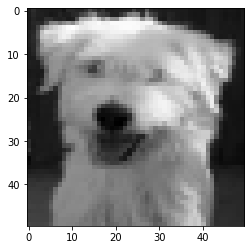

In [ ]:
dataset = []

# 0 = cat
# 1 = dog
show = True
for path in tqdm.tqdm(glob.glob("/content/kagglecatsanddogs_3367a/PetImages/Cat/*")):
  try:
    img = Image.open(path).convert("L").resize((50,50))
    if show:
      plt.imshow(img, cmap='gray')
      show = False
    
    dataset.append([np.array(img, dtype=np.float64) / 255, 0])
    dataset.append([np.array(img.transpose(Image.FLIP_LEFT_RIGHT), dtype=np.float64) / 255, 0])
    
  except Exception as e:
    print(e)

show = True
for path in tqdm.tqdm(glob.glob("/content/kagglecatsanddogs_3367a/PetImages/Dog/*")):
  try:
    img = Image.open(path).convert("L").resize((50,50))
    if show:
      plt.imshow(img, cmap='gray')
      show = False
    
    dataset.append([np.array(img, dtype=np.float64) / 255, 1])
    dataset.append([np.array(img.transpose(Image.FLIP_LEFT_RIGHT), dtype=np.float64) / 255, 1])
  except Exception as e:
    print(e)

np.save("dataset.npy", np.array(dataset, dtype=object))

In [ ]:
dataset = np.load("drive/MyDrive/dataset.npy", allow_pickle=True)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.network = nn.Sequential(
      nn.Conv2d(1, 50, kernel_size=5),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.BatchNorm2d(50),

      nn.Conv2d(50, 100, kernel_size=5),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Flatten(),

      nn.Linear(8100, 500),
      nn.ReLU(),
      nn.BatchNorm1d(500),

      nn.Linear(500, 125),
      nn.ReLU(),

      nn.Linear(125, 2),
      nn.Softmax(dim=1)
    )

  def forward(self, x):
    return self.network(x)

In [ ]:
model = Net()
optimizer = Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    loss_function = loss_function.cuda()


In [ ]:
epoch = 1000
np.random.shuffle(dataset)

train = dataset[:22463*2]
test = dataset[22464*2:]

for i in range(epoch):
  np.random.shuffle(train)
  np.random.shuffle(test)

  correct = 0
  total = 0

  model.eval()
  for data in test:
    x, y = data
    x = torch.from_numpy(x)
    y = torch.from_numpy(np.eye(2)[y])

    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()

    x = x.view(1, 1, x.shape[0], x.shape[1]).float()
    
    output = model(x)

    if False not in (torch.round(output) == y):
      correct+=1
    
    total+=1
  accuracy = (correct/total) * 100

  print(f"Epoch {i} Accuracy: {accuracy}")

  model.train() 
  for i in tqdm.tqdm(range(1, int(len(train) / 32))):
    data = train[(i-1)*32:i*32]

    x = np.array([d[0] for d in data])
    y = np.array([d[1] for d in data])

                           
    x = torch.from_numpy(x)
    y = torch.from_numpy(y).long()
    
    
    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()

    x = x.view(32, 1, 50, 50).float()
    
    optimizer.zero_grad()
    output = model(x)


    loss = loss_function(output, y)

    loss.backward()
    optimizer.step()
  
  if i % 10 == 0:
    print("saving...")
    torch.save(model.state_dict(), "drive/MyDrive/models/catvsdog.pth")

Epoch 0 Accuracy: 49.69939879759519


100%|██████████| 1402/1402 [00:22<00:00, 62.22it/s]


Epoch 1 Accuracy: 76.55310621242485


100%|██████████| 1402/1402 [00:22<00:00, 62.30it/s]


Epoch 2 Accuracy: 78.13627254509018


100%|██████████| 1402/1402 [00:22<00:00, 62.41it/s]


Epoch 3 Accuracy: 78.77755511022045


100%|██████████| 1402/1402 [00:22<00:00, 62.52it/s]


Epoch 4 Accuracy: 80.74148296593187


100%|██████████| 1402/1402 [00:22<00:00, 62.59it/s]


Epoch 5 Accuracy: 78.67735470941884


100%|██████████| 1402/1402 [00:22<00:00, 62.61it/s]


Epoch 6 Accuracy: 82.66533066132264


100%|██████████| 1402/1402 [00:22<00:00, 62.63it/s]


Epoch 7 Accuracy: 81.7434869739479


100%|██████████| 1402/1402 [00:22<00:00, 62.66it/s]


Epoch 8 Accuracy: 81.62324649298597


100%|██████████| 1402/1402 [00:22<00:00, 62.63it/s]


Epoch 9 Accuracy: 81.20240480961924


100%|██████████| 1402/1402 [00:22<00:00, 62.66it/s]


Epoch 10 Accuracy: 80.38076152304609


100%|██████████| 1402/1402 [00:22<00:00, 62.63it/s]


Epoch 11 Accuracy: 82.34468937875752


100%|██████████| 1402/1402 [00:22<00:00, 62.66it/s]


Epoch 12 Accuracy: 81.84368737474949


100%|██████████| 1402/1402 [00:22<00:00, 62.71it/s]


Epoch 13 Accuracy: 81.9438877755511


100%|██████████| 1402/1402 [00:22<00:00, 62.72it/s]


Epoch 14 Accuracy: 81.96392785571143


100%|██████████| 1402/1402 [00:22<00:00, 62.71it/s]


Epoch 15 Accuracy: 81.58316633266534


100%|██████████| 1402/1402 [00:22<00:00, 62.73it/s]


Epoch 16 Accuracy: 81.34268537074149


100%|██████████| 1402/1402 [00:22<00:00, 62.78it/s]


Epoch 17 Accuracy: 82.14428857715431


100%|██████████| 1402/1402 [00:22<00:00, 62.74it/s]


Epoch 18 Accuracy: 81.54308617234469


100%|██████████| 1402/1402 [00:22<00:00, 62.70it/s]


Epoch 19 Accuracy: 81.52304609218437


100%|██████████| 1402/1402 [00:22<00:00, 62.74it/s]


Epoch 20 Accuracy: 81.78356713426854


100%|██████████| 1402/1402 [00:22<00:00, 62.72it/s]


Epoch 21 Accuracy: 81.52304609218437


100%|██████████| 1402/1402 [00:22<00:00, 62.71it/s]


Epoch 22 Accuracy: 81.58316633266534


100%|██████████| 1402/1402 [00:22<00:00, 62.70it/s]


Epoch 23 Accuracy: 82.00400801603206


100%|██████████| 1402/1402 [00:22<00:00, 62.58it/s]


Epoch 24 Accuracy: 82.38476953907815


100%|██████████| 1402/1402 [00:22<00:00, 62.72it/s]


Epoch 25 Accuracy: 81.90380761523046


100%|██████████| 1402/1402 [00:22<00:00, 62.70it/s]


Epoch 26 Accuracy: 80.26052104208416


100%|██████████| 1402/1402 [00:22<00:00, 62.63it/s]


Epoch 27 Accuracy: 81.24248496993988


100%|██████████| 1402/1402 [00:22<00:00, 62.69it/s]


Epoch 28 Accuracy: 81.04208416833667


100%|██████████| 1402/1402 [00:22<00:00, 62.70it/s]


Epoch 29 Accuracy: 82.0440881763527


100%|██████████| 1402/1402 [00:22<00:00, 62.77it/s]


Epoch 30 Accuracy: 80.06012024048096


100%|██████████| 1402/1402 [00:22<00:00, 62.76it/s]


Epoch 31 Accuracy: 81.40280561122243


100%|██████████| 1402/1402 [00:22<00:00, 62.78it/s]


Epoch 32 Accuracy: 80.92184368737475


100%|██████████| 1402/1402 [00:22<00:00, 62.74it/s]


Epoch 33 Accuracy: 81.66332665330661


100%|██████████| 1402/1402 [00:22<00:00, 62.76it/s]


Epoch 34 Accuracy: 82.02404809619239


100%|██████████| 1402/1402 [00:22<00:00, 62.76it/s]


Epoch 35 Accuracy: 81.80360721442885


100%|██████████| 1402/1402 [00:22<00:00, 62.79it/s]


Epoch 36 Accuracy: 81.38276553106213


100%|██████████| 1402/1402 [00:22<00:00, 62.81it/s]


Epoch 37 Accuracy: 81.62324649298597


100%|██████████| 1402/1402 [00:22<00:00, 62.77it/s]


Epoch 38 Accuracy: 82.50501002004007


100%|██████████| 1402/1402 [00:22<00:00, 62.73it/s]


Epoch 39 Accuracy: 81.60320641282564


100%|██████████| 1402/1402 [00:22<00:00, 62.73it/s]


Epoch 40 Accuracy: 81.42284569138276


100%|██████████| 1402/1402 [00:22<00:00, 62.70it/s]


Epoch 41 Accuracy: 81.80360721442885


100%|██████████| 1402/1402 [00:22<00:00, 62.70it/s]


Epoch 42 Accuracy: 81.84368737474949


100%|██████████| 1402/1402 [00:22<00:00, 62.69it/s]


Epoch 43 Accuracy: 82.14428857715431


100%|██████████| 1402/1402 [00:22<00:00, 62.72it/s]


Epoch 44 Accuracy: 81.4629258517034


100%|██████████| 1402/1402 [00:22<00:00, 62.74it/s]


Epoch 45 Accuracy: 82.0440881763527


100%|██████████| 1402/1402 [00:22<00:00, 62.73it/s]


Epoch 46 Accuracy: 80.20040080160321


100%|██████████| 1402/1402 [00:22<00:00, 62.72it/s]


Epoch 47 Accuracy: 81.7434869739479


100%|██████████| 1402/1402 [00:22<00:00, 62.72it/s]


Epoch 48 Accuracy: 82.02404809619239


100%|██████████| 1402/1402 [00:22<00:00, 62.69it/s]


Epoch 49 Accuracy: 81.76352705410822


100%|██████████| 1402/1402 [00:22<00:00, 62.71it/s]


Epoch 50 Accuracy: 82.12424849699399


100%|██████████| 1402/1402 [00:22<00:00, 62.68it/s]


Epoch 51 Accuracy: 81.86372745490982


100%|██████████| 1402/1402 [00:22<00:00, 62.61it/s]


Epoch 52 Accuracy: 81.52304609218437


100%|██████████| 1402/1402 [00:22<00:00, 62.64it/s]


Epoch 53 Accuracy: 81.42284569138276


100%|██████████| 1402/1402 [00:22<00:00, 62.55it/s]


Epoch 54 Accuracy: 81.92384769539078


100%|██████████| 1402/1402 [00:22<00:00, 62.74it/s]


Epoch 55 Accuracy: 82.28456913827655


100%|██████████| 1402/1402 [00:22<00:00, 62.69it/s]


Epoch 56 Accuracy: 82.24448897795591


100%|██████████| 1402/1402 [00:22<00:00, 62.66it/s]


Epoch 57 Accuracy: 82.24448897795591


100%|██████████| 1402/1402 [00:22<00:00, 62.68it/s]


Epoch 58 Accuracy: 81.90380761523046


100%|██████████| 1402/1402 [00:22<00:00, 62.52it/s]


Epoch 59 Accuracy: 82.00400801603206


100%|██████████| 1402/1402 [00:22<00:00, 62.70it/s]


Epoch 60 Accuracy: 81.90380761523046


100%|██████████| 1402/1402 [00:22<00:00, 62.69it/s]


Epoch 61 Accuracy: 81.86372745490982


100%|██████████| 1402/1402 [00:22<00:00, 62.65it/s]


Epoch 62 Accuracy: 82.16432865731463


100%|██████████| 1402/1402 [00:22<00:00, 62.65it/s]


Epoch 63 Accuracy: 82.12424849699399


100%|██████████| 1402/1402 [00:22<00:00, 62.65it/s]


Epoch 64 Accuracy: 81.92384769539078


100%|██████████| 1402/1402 [00:22<00:00, 62.61it/s]


Epoch 65 Accuracy: 82.06412825651303


100%|██████████| 1402/1402 [00:22<00:00, 62.39it/s]


Epoch 66 Accuracy: 80.94188376753507


100%|██████████| 1402/1402 [00:22<00:00, 61.95it/s]


Epoch 67 Accuracy: 82.46492985971943


100%|██████████| 1402/1402 [00:22<00:00, 61.75it/s]


Epoch 68 Accuracy: 82.36472945891784


100%|██████████| 1402/1402 [00:22<00:00, 61.68it/s]


Epoch 69 Accuracy: 82.0440881763527


100%|██████████| 1402/1402 [00:22<00:00, 61.70it/s]


Epoch 70 Accuracy: 82.26452905811624


100%|██████████| 1402/1402 [00:22<00:00, 61.70it/s]


Epoch 71 Accuracy: 82.02404809619239


100%|██████████| 1402/1402 [00:22<00:00, 61.80it/s]


Epoch 72 Accuracy: 81.2625250501002


100%|██████████| 1402/1402 [00:22<00:00, 61.77it/s]


Epoch 73 Accuracy: 81.64328657314628


100%|██████████| 1402/1402 [00:22<00:00, 61.75it/s]


Epoch 74 Accuracy: 81.48296593186373


100%|██████████| 1402/1402 [00:22<00:00, 61.81it/s]


Epoch 75 Accuracy: 81.52304609218437


100%|██████████| 1402/1402 [00:22<00:00, 61.75it/s]


Epoch 76 Accuracy: 81.50300601202404


100%|██████████| 1402/1402 [00:22<00:00, 61.71it/s]


Epoch 77 Accuracy: 82.22444889779558


100%|██████████| 1402/1402 [00:22<00:00, 61.72it/s]


Epoch 78 Accuracy: 81.58316633266534


100%|██████████| 1402/1402 [00:22<00:00, 61.70it/s]


Epoch 79 Accuracy: 81.12224448897796


100%|██████████| 1402/1402 [00:22<00:00, 61.76it/s]


Epoch 80 Accuracy: 81.9438877755511


100%|██████████| 1402/1402 [00:22<00:00, 61.79it/s]


Epoch 81 Accuracy: 82.42484969939879


100%|██████████| 1402/1402 [00:22<00:00, 61.81it/s]


Epoch 82 Accuracy: 82.0440881763527


100%|██████████| 1402/1402 [00:22<00:00, 61.75it/s]


Epoch 83 Accuracy: 82.18436873747495


100%|██████████| 1402/1402 [00:22<00:00, 61.78it/s]


Epoch 84 Accuracy: 82.54509018036073


100%|██████████| 1402/1402 [00:22<00:00, 61.78it/s]


Epoch 85 Accuracy: 82.40480961923848


100%|██████████| 1402/1402 [00:22<00:00, 61.75it/s]


Epoch 86 Accuracy: 81.86372745490982


100%|██████████| 1402/1402 [00:22<00:00, 61.72it/s]


Epoch 87 Accuracy: 82.36472945891784


100%|██████████| 1402/1402 [00:22<00:00, 61.79it/s]


Epoch 88 Accuracy: 82.28456913827655


100%|██████████| 1402/1402 [00:22<00:00, 61.85it/s]


Epoch 89 Accuracy: 81.88376753507013


100%|██████████| 1402/1402 [00:22<00:00, 61.75it/s]


Epoch 90 Accuracy: 82.22444889779558


100%|██████████| 1402/1402 [00:22<00:00, 61.77it/s]


Epoch 91 Accuracy: 82.26452905811624


100%|██████████| 1402/1402 [00:22<00:00, 61.82it/s]


Epoch 92 Accuracy: 81.88376753507013


100%|██████████| 1402/1402 [00:22<00:00, 61.77it/s]


Epoch 93 Accuracy: 81.80360721442885


100%|██████████| 1402/1402 [00:22<00:00, 61.76it/s]


Epoch 94 Accuracy: 82.12424849699399


100%|██████████| 1402/1402 [00:22<00:00, 61.76it/s]


Epoch 95 Accuracy: 82.22444889779558


100%|██████████| 1402/1402 [00:22<00:00, 61.85it/s]


Epoch 96 Accuracy: 81.44288577154309


100%|██████████| 1402/1402 [00:22<00:00, 61.83it/s]


Epoch 97 Accuracy: 82.0440881763527


100%|██████████| 1402/1402 [00:22<00:00, 61.85it/s]


Epoch 98 Accuracy: 82.10420841683367


100%|██████████| 1402/1402 [00:22<00:00, 61.75it/s]


Epoch 99 Accuracy: 80.26052104208416


100%|██████████| 1402/1402 [00:22<00:00, 61.85it/s]


Epoch 100 Accuracy: 81.3627254509018


100%|██████████| 1402/1402 [00:22<00:00, 61.82it/s]


Epoch 101 Accuracy: 82.02404809619239


100%|██████████| 1402/1402 [00:22<00:00, 61.84it/s]


Epoch 102 Accuracy: 82.30460921843688


100%|██████████| 1402/1402 [00:22<00:00, 61.76it/s]


Epoch 103 Accuracy: 82.26452905811624


100%|██████████| 1402/1402 [00:22<00:00, 61.75it/s]


Epoch 104 Accuracy: 82.02404809619239


100%|██████████| 1402/1402 [00:22<00:00, 61.59it/s]


Epoch 105 Accuracy: 81.72344689378758


100%|██████████| 1402/1402 [00:22<00:00, 61.58it/s]


Epoch 106 Accuracy: 81.72344689378758


100%|██████████| 1402/1402 [00:22<00:00, 61.67it/s]


Epoch 107 Accuracy: 81.62324649298597


100%|██████████| 1402/1402 [00:22<00:00, 61.81it/s]


Epoch 108 Accuracy: 82.42484969939879


100%|██████████| 1402/1402 [00:22<00:00, 61.73it/s]


Epoch 109 Accuracy: 81.10220440881764


100%|██████████| 1402/1402 [00:22<00:00, 61.61it/s]


Epoch 110 Accuracy: 81.98396793587175


100%|██████████| 1402/1402 [00:22<00:00, 61.75it/s]


Epoch 111 Accuracy: 82.12424849699399


100%|██████████| 1402/1402 [00:22<00:00, 61.59it/s]


Epoch 112 Accuracy: 82.76553106212425


100%|██████████| 1402/1402 [00:22<00:00, 61.72it/s]


Epoch 113 Accuracy: 82.30460921843688


100%|██████████| 1402/1402 [00:22<00:00, 61.63it/s]


Epoch 114 Accuracy: 81.7434869739479


100%|██████████| 1402/1402 [00:22<00:00, 61.74it/s]


Epoch 115 Accuracy: 82.14428857715431


100%|██████████| 1402/1402 [00:22<00:00, 61.79it/s]


Epoch 116 Accuracy: 82.42484969939879


100%|██████████| 1402/1402 [00:22<00:00, 61.78it/s]


Epoch 117 Accuracy: 82.20440881763527


100%|██████████| 1402/1402 [00:22<00:00, 61.73it/s]


Epoch 118 Accuracy: 82.14428857715431


100%|██████████| 1402/1402 [00:22<00:00, 61.70it/s]


Epoch 119 Accuracy: 82.16432865731463


100%|██████████| 1402/1402 [00:22<00:00, 61.75it/s]


Epoch 120 Accuracy: 82.06412825651303


100%|██████████| 1402/1402 [00:22<00:00, 61.68it/s]


Epoch 121 Accuracy: 81.30260521042084


100%|██████████| 1402/1402 [00:22<00:00, 61.87it/s]


Epoch 122 Accuracy: 82.16432865731463


100%|██████████| 1402/1402 [00:22<00:00, 61.78it/s]


Epoch 123 Accuracy: 82.88577154308618


 29%|██▉       | 411/1402 [00:06<00:16, 61.78it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), "drive/MyDrive/models/catvsdog.pth")

In [ ]:
def predict(img):
  model.eval()
  img = img.convert("L").resize((50 , 50))
  img = np.array(img, dtype=np.float64) / 255

  x = torch.from_numpy(img)

  if torch.cuda.is_available():
    x = x.cuda()

  x = x.view(1, 1, 50,50).float()

  output = model(x)
  print(f"Cat: {int(output.flatten()[0] * 100)}%")
  print(f"Dog: {int(output.flatten()[1] * 100)}%")

In [ ]:
import urllib.request
url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.D2su1F8BxoIqnBrqJpDPEwHaE8%26pid%3DApi&f=1"
urllib.request.urlretrieve(url, "img.jpeg")

('img.jpeg', <http.client.HTTPMessage at 0x7f945ac6d150>)

Cat: 100%
Dog: 0%


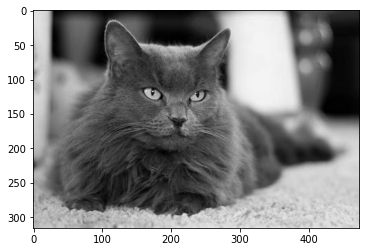

In [ ]:
img = Image.open("img.jpeg")
plt.imshow(img)
predict(img)